##  **Audio Sound source Separation Using Non-Negative Matrix Factorization**

---


**Import libraries**

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import librosa
import librosa.display
import IPython.display as ipd

### **01. Prepare the data**

**Load audio recording**

In [3]:
audio_file = '/Users/ziaoyou/WorkSpace/CodeSpace/Projects/HeartDiseasePrediction/assets/the-circor-digiscope-phonocardiogram-dataset-1.0.3/training_data/14241_TV.wav'

**Listen to audio recording**

In [4]:
sample_rate = 4000
# Load audio signal
audio_sound, sr = librosa.load(audio_file, sr = sample_rate)
# Display audio
ipd.Audio(audio_sound,rate = sr)

**Show the sound's waveform**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


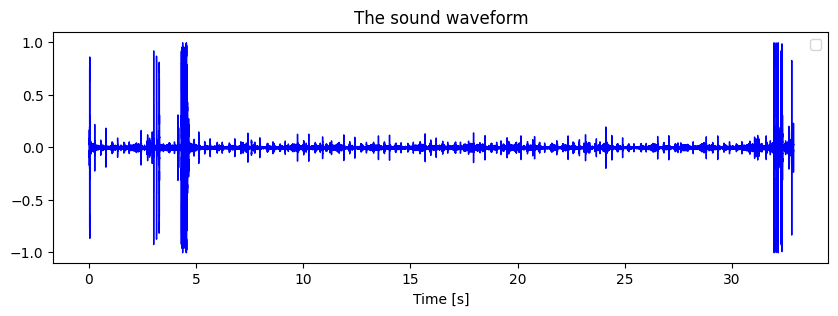

In [5]:
# Plotting the sound's waveform
fig, ax = plt.subplots(figsize=(10, 3))
librosa.display.waveshow(audio_sound, sr=sr, ax=ax, color='blue')
ax.set(title='The sound waveform',
       xlabel='Time [s]')
ax.legend()

### **02. Compute Short Term Fourier Transform of the signal**

In [6]:
FRAME = 512
HOP = 256

# Return the complex Short Term Fourier Transform
sound_stft = librosa.stft(audio_sound, n_fft = FRAME, hop_length = HOP)

Text(0.5, 1.0, 'Audio spectrogram')

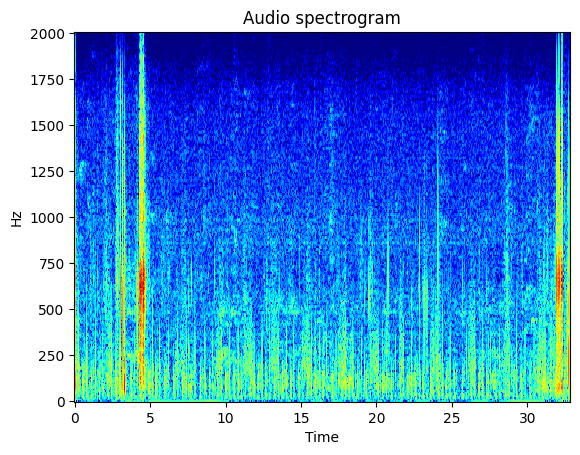

In [7]:
# Magnitude Spectrogram
sound_stft_Magnitude = np.abs(sound_stft)

# Phase spectrogram
sound_stft_Angle = np.angle(sound_stft)

#Plot Spectogram
Spec = librosa.amplitude_to_db(sound_stft_Magnitude, ref = np.max)
librosa.display.specshow(Spec,y_axis = 'hz',sr=sr,hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet)
plt.title('Audio spectrogram')

### **03. Non-Negative Matrix Factorisation**

In [8]:
epsilon = 1e-10 # error to introduce
V = sound_stft_Magnitude + epsilon
K, N = np.shape(V)
S = 3 ###########
print(f"S = {S} : Number of Sources to separate")

S = 3 : Number of Sources to separate


**Define a fonction that computes the $\beta$ Divergence**

In [9]:
def divergence(V,W,H, beta = 2):
    
    """
    beta = 2 : Euclidean cost function
    beta = 1 : Kullback-Leibler cost function
    beta = 0 : Itakura-Saito cost function
    """ 
    
    if beta == 0 : return np.sum( V/(W@H) - math.log10(V/(W@H)) -1 )
    
    if beta == 1 : return np.sum( V*math.log10(V/(W@H)) + (W@H - V))
    
    if beta == 2 : return 1/2*np.linalg.norm(W@H-V)
    

**Define a visualization function**

In [10]:
def plot_NMF_iter(W, H,beta,iteration = None):
    
    f = plt.figure(figsize=(4,4))
    f.suptitle(f"NMF Iteration {iteration}, for beta = {beta}", fontsize=8,)
    
    # definitions for the axes
    V_plot = plt.axes([0.35, 0.1, 1, 0.6])
    H_plot = plt.axes([0.35, 0.75, 1, 0.15])
    W_plot = plt.axes([0.1, 0.1, 0.2, 0.6])

    D = librosa.amplitude_to_db(W@H, ref = np.max)

    librosa.display.specshow(W,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=W_plot)
    librosa.display.specshow(H,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=H_plot)
    librosa.display.specshow(D,y_axis = 'hz', sr=sr, hop_length=HOP,x_axis ='time',cmap= matplotlib.cm.jet, ax=V_plot)

    W_plot.set_title('Dictionnary W', fontsize=10)
    H_plot.set_title('Temporal activations H', fontsize=10)

    W_plot.axes.get_xaxis().set_visible(False)
    H_plot.axes.get_xaxis().set_visible(False)
    V_plot.axes.get_yaxis().set_visible(False)

**Define main NMF function**

In [11]:
def NMF(V, S, beta = 2,  threshold = 0.05, MAXITER = 5000, display = True , displayEveryNiter = None): 
    
    """
    inputs : 
    --------
    
        V         : Mixture signal : |TFST|
        S         : The number of sources to extract
        beta      : Beta divergence considered, default=2 (Euclidean)
        threshold : Stop criterion 
        MAXITER   : The number of maximum iterations, default=1000
        display   : Display plots during optimization : 
        displayEveryNiter : only display last iteration 
                                                            
    
    outputs :
    ---------
      
        W : dictionary matrix [KxS], W>=0
        H : activation matrix [SxN], H>=0
        cost_function : the optimised cost function over iterations
       
   Algorithm : 
   -----------
   
    1) Randomly initialize W and H matrices
    2) Multiplicative update of W and H 
    3) Repeat step (2) until convergence or after MAXITER 
    
       
    """
    counter  = 0
    cost_function = []
    beta_divergence = 1
    
    K, N = np.shape(V)
    
    # Initialisation of W and H matrices : The initialization is generally random
    W = np.abs(np.random.normal(loc=0, scale = 2.5, size=(K,S)))    
    H = np.abs(np.random.normal(loc=0, scale = 2.5, size=(S,N)))
    
    # Plotting the first initialization
    if display == True : plot_NMF_iter(W,H,beta,counter)


    while beta_divergence >= threshold and counter <= MAXITER:
        
        # Update of W and H
        H *= (W.T@(((W@H)**(beta-2))*V))/(W.T@((W@H)**(beta-1)) + 10e-10)
        W *= (((W@H)**(beta-2)*V)@H.T)/((W@H)**(beta-1)@H.T + 10e-10)
        
        
        # Compute cost function
        beta_divergence =  divergence(V,W,H, beta = 2)
        cost_function.append( beta_divergence )
        
        if  display == True  and counter%displayEveryNiter == 0  : plot_NMF_iter(W,H,beta,counter)

        counter +=1
    
    if counter -1 == MAXITER : print(f"Stop after {MAXITER} iterations.")
    else : print(f"Convergeance after {counter-1} iterations.")
        
    return W,H, cost_function 

**Call function**

In [12]:
beta = 2
W, H, cost_function = NMF(V,S,beta = beta, threshold = 0.05, MAXITER = 5000, display = False , displayEveryNiter = 1000)

Stop after 5000 iterations.


**Plotting the cost Function**

Text(0, 0.5, 'Beta Divergence for beta = 2 ')

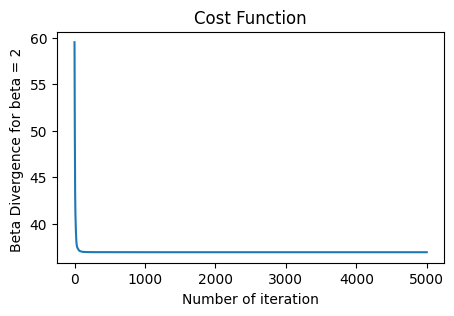

In [13]:
# Plot the cost function
plt.figure(figsize=(5,3))
plt.plot(cost_function)
plt.title("Cost Function")
plt.xlabel("Number of iteration")
plt.ylabel(f"Beta Divergence for beta = {beta} ")

In [14]:
W

array([[2.26289710e-001, 1.70525361e+000, 2.89277899e-001],
       [4.04765373e-001, 2.04870535e+000, 2.30114239e-001],
       [8.94376319e-001, 3.26603269e+000, 2.99866033e-002],
       [8.69730946e-001, 4.98218798e+000, 4.17429616e-002],
       [6.94830080e-001, 5.76992190e+000, 1.49931509e-001],
       [1.06394086e-001, 6.45284467e+000, 5.62544430e-001],
       [4.94065646e-324, 8.63444270e+000, 5.58864268e-001],
       [1.48219694e-323, 1.23716369e+001, 7.77590710e-010],
       [2.27643899e-230, 1.59473081e+001, 7.74386226e-001],
       [4.94065646e-324, 1.88163286e+001, 2.00228420e+000],
       [9.88131292e-324, 2.09064894e+001, 1.70440456e+000],
       [3.51626782e-006, 2.19778297e+001, 8.13548357e-001],
       [2.89503637e+000, 2.11646417e+001, 5.02229413e-087],
       [2.75017775e+000, 1.89057260e+001, 5.33795579e-001],
       [1.82526516e+000, 1.62887348e+001, 7.32111824e-001],
       [4.42442905e-001, 1.45581850e+001, 1.96126736e+000],
       [7.47321269e-001, 1.38099005e+001

---------------